In [11]:
import numpy as np
import matplotlib.pyplot as plt

# SPC retention (Eq. 11)
a1_spc, k1 = 0.1787, 0.5337
a2_spc, k2 = 0.8237, 0.00997

# IRF parameters (Jeltsch-Thömmes & Joos, 2019)
a0 = 0.008
a  = np.array([0.044, 0.112, 0.224, 0.310, 0.297], dtype=float)
tau = np.array([68521.0, 5312.0, 362.0, 47.0, 6.0], dtype=float)

# Methane reference
GWP100_CH4 = 27.0
IRFint100 = 50.480844011106
M_CH4 = 1.0


In [12]:
def f_SPC(t):
    t = np.asarray(t, dtype=float)
    return a1_spc*np.exp(-k1*t) + a2_spc*np.exp(-k2*t)

def IRF(t):
    t = np.asarray(t, dtype=float)
    if t.ndim == 0:
        return a0 + np.sum(a*np.exp(-t/tau))
    return a0 + np.sum(a*np.exp(-t[:, None]/tau), axis=1)

def y(t):
    return f_SPC(t) * IRF(t)

def trapz(yvals, xvals):
    yvals = np.asarray(yvals, dtype=float)
    xvals = np.asarray(xvals, dtype=float)
    return np.sum((yvals[1:] + yvals[:-1]) * 0.5 * (xvals[1:] - xvals[:-1]))

def I_numeric(H, n=20_000):
    t = np.linspace(0.0, float(H), n+1)
    return trapz(y(t), t)

def I_analytic(H):
    H = float(H)

    const_part = a0 * (
        a1_spc*(1.0 - np.exp(-k1*H))/k1 +
        a2_spc*(1.0 - np.exp(-k2*H))/k2
    )

    exp_part = 0.0
    for ai, taui in zip(a, tau):
        lam = 1.0/taui
        exp_part += ai * (
            a1_spc*(1.0 - np.exp(-(k1 + lam)*H))/(k1 + lam) +
            a2_spc*(1.0 - np.exp(-(k2 + lam)*H))/(k2 + lam)
        )

    return const_part + exp_part

def TCE_CH4_100(M_CH4=1.0, GWP100_CH4=27.0):
    return M_CH4 * GWP100_CH4 * IRFint100

def TCE_SPC(H, M_sink):
    return -M_sink * I_analytic(H)

def M_sink_required(H, M_CH4=1.0, GWP100_CH4=27.0):
    return TCE_CH4_100(M_CH4, GWP100_CH4) / I_analytic(H)



--- Kernel integral for the diminishing SPC sink ---
I(H) = ∫_0^H f_SPC(t) · IRF(t) dt   [units: years]
Analytic (exact) value            = 11.151239311334 yr   <-- use this
Numeric trapezoid check (n=20000)   = 11.151239323956 yr
Absolute difference (check-error) = 1.262e-08 yr

Therefore: TCE_SPC(H) = -M_sink * I(H) = -M_sink * 11.151239 (tCO2e·yr per tCO2e)

--- Methane offsetting with diminishing SPC sink (H = 20 yr) ---

TCE_CH4(100) for 1.000 tCH4 (GWP100 = 27.0) = 1362.982788 tCO2e·yr
I(H) = ∫_0^H f_SPC(t)·IRF(t) dt = 11.151239 yr

M_sink_required(20) = 122.227023 tCO2e
TCE_SPC(20) for M_sink = 122.227023 tCO2e = -1362.982788 tCO2e·yr

Offset check:  TCE_CH4(100) + TCE_SPC(20) = 0.000000 tCO2e·yr


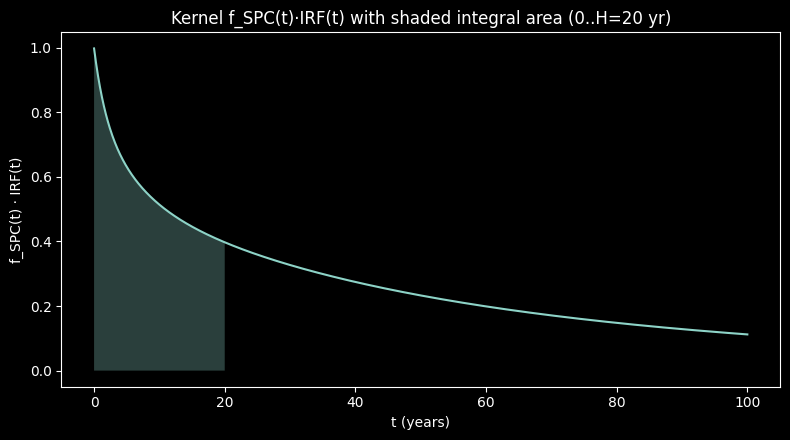

In [13]:
# --- user choices
H = 20
M_sink = 1.0      # tCO2e, for the TCE calculation
n = 20_000

# You must have defined these earlier in the notebook:
# M_CH4 = 1.0
# GWP100_CH4 = 27.0

I_a = I_analytic(H)
I_n = I_numeric(H, n=n)

tce_sink = TCE_SPC(H, M_sink)
tce_ch4  = TCE_CH4_100(M_CH4, GWP100_CH4)
M_req    = M_sink_required(H, M_CH4, GWP100_CH4)

print("\n--- Kernel integral for the diminishing SPC sink ---")
print("I(H) = ∫_0^H f_SPC(t) · IRF(t) dt   [units: years]")
print(f"Analytic (exact) value            = {I_a:.12f} yr   <-- use this")
print(f"Numeric trapezoid check (n={n})   = {I_n:.12f} yr")
print(f"Absolute difference (check-error) = {abs(I_n - I_a):.3e} yr")

print(f"\nTherefore: TCE_SPC(H) = -M_sink * I(H) = -M_sink * {I_a:.6f} (tCO2e·yr per tCO2e)")

print(f"\n--- Methane offsetting with diminishing SPC sink (H = {H} yr) ---\n")

print(f"TCE_CH4(100) for {M_CH4:.3f} tCH4 (GWP100 = {GWP100_CH4:.1f}) "
      f"= {tce_ch4:.6f} tCO2e·yr")

print(f"I(H) = ∫_0^H f_SPC(t)·IRF(t) dt = {I_a:.6f} yr")

print(f"\nM_sink_required({H}) = {M_req:.6f} tCO2e")

print(f"TCE_SPC({H}) for M_sink = {M_req:.6f} tCO2e "
      f"= {-M_req*I_a:.6f} tCO2e·yr")

print(f"\nOffset check:  TCE_CH4(100) + TCE_SPC({H}) "
      f"= {tce_ch4 + (-M_req*I_a):.6f} tCO2e·yr")


tmax = 100
dt = 0.1

t = np.arange(0.0, tmax + dt, dt)
yvals = y(t)
mask = (t <= H)

plt.figure(figsize=(8, 4.5))
plt.plot(t, yvals)
plt.fill_between(t[mask], 0, yvals[mask], alpha=0.3)
plt.xlabel("t (years)")
plt.ylabel("f_SPC(t) · IRF(t)")
plt.title(f"Kernel f_SPC(t)·IRF(t) with shaded integral area (0..H={H} yr)")
plt.tight_layout()
plt.show()
